# Generación de datos HH 1 Caja


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuron import h,rxd
import pandas as pd
import csv
h.load_file("stdrun.hoc")

1.0

In [2]:
!pip install detecta
from detecta import detect_peaks

In [29]:
def sim_HH_1_box(volt_inicial, physical_var,loc, curr ,tstop,dt):
    """
    Obtención de datos para el modelo HH con los parámetros params
    
    Resuelve el sistema hasta un tiempo tstop con los parámetros entregados
    
    params: voltaje inicial 
    physical_var: Lista con variables físicas [largo_axon, diametro_axon]
    loc: Localizacion del estimulo
    curr: Parámetros de la corriente aplicada [amplitud, duracion, delay]
    """
    
    #Crear axon
    axon = h.Section()
    axon.L = physical_var[0] #Largo
    axon.diam = physical_var[1] #Diametro
    
    axon.insert("hh") #Mecanismo: hh
    mech = axon().hh
    
    #Estimulo: Corriente I(t)
    Istim = h.IClamp(loc,sec = axon) #Estimulo en el axon
    Istim.amp = curr[0] #Amplitud
    Istim.dur = curr[1] #Duracion 
    Istim.delay = curr[2] #Retardo
    #Clase vector con np
    #Istim -> play
    #vector.play(Istim)
    
    #Duracion de la simulacion
    h.tstop = tstop
    h.dt = dt #Particion del tiempo

    #states m,n,h gate variables
    state_m = h.Vector()
    state_m.record(axon().hh._ref_m)
    
    state_n = h.Vector()
    state_n.record(axon().hh._ref_n)
    
    state_h = h.Vector()
    state_h.record(axon().hh._ref_h)
    #membrane potential
    
    v_axon = h.Vector()
    h.v_init = volt_inicial #inicializar voltaje
    v_axon.record(axon()._ref_v)
    
    #timestamp vector
    t = h.Vector()
    t.record(h._ref_t)
    
    h.init()
    h.run()
    return v_axon,state_m,state_n,state_h

In [6]:
def generate_data_hh(save_data, tstop, dt ,v_min,v_max, amp_min, amp_max, max_delay , max_dur,localizacion_est,largo_axon, diametro_axon):
    """
    save_data: Boolean indicates if the data is going to be saved or not 
    tstop: Final time for the simulation
    dt: Time step
    v_min: Minimal value of the voltage 
    v_max: Maximum value of the voltage
    amp_min: Minimal amplitud of the current
    amp_max: Maximum amplitud of the current
    max_delay: Max value of the delay. It will be assumed that the minimal value of the delay is 0 (no delay)
    max_dur: Maximum value of the duration of the stimulus. The minimal value is set 0
    localizacion_est: Localization of the stimulus
    largo_axon: Length of the axon
    diametro_axon: Diameter of the axon
    """
    largo = int(1/dt)*tstop  #Largo de los datos
    V_range = np.linspace(v_min,v_max, 20) #Rango de voltajes
    I_range = np.linspace(amp_min,amp_max, 20) #Rango de corrientes
    I_delay = np.linspace(0,max_delay,10) #Retardos
    I_dur = np.linspace(0, max_dur, 10)#duracion
    save_data = save_data
    
    nombres = [] #lista con nombres de los archivos
    #DataFrame vacio para guardar cada experimento
    data = pd.DataFrame(columns = ["V","m","n","h"],index=  np.linspace(0,tstop,largo+1))
    parametros = pd.DataFrame(columns = ["V_initial","I_initial","Duration","Delay"],index=  np.linspace(0,tstop,largo+1))
    #Experimentos
    k=0
    for v in V_range:
        for i in I_range:
            for delay in I_delay:
                for duration in I_dur:
                    init_cond = v
                    phys = [largo_axon,diametro_axon]
                    loc = localizacion_est
                    curr = [i,duration,delay] 
                    states = sim_HH_1_box(init_cond,phys,loc,curr,tstop,dt)
                    data["V"]=[volt for volt in states[0]]
                    data["m"] = [round(m,4) for m in states[1]]
                    data["n"] = [round(n,4) for n in states[2]]
                    data["h"] = [round(h,4) for h in states[3]]
                    
                    parametros["V_initial"] = v
                    parametros["I_initial"] = i
                    parametros["Duration"] = duration
                    parametros["Delay"] = delay
                    
                    if save_data:
                        name = "dataHH_1box_exp"+ str(k)+".csv"
                        name_par = "paramsHH_1box_exp"+ str(k)+".csv"
                        nombres.append(name+"\n")
                        data.to_csv("C:/Users/DELL/Desktop/ACIP/Tutorial NEURON/data_HH/"+name)
                        parametros.to_csv("C:/Users/DELL/Desktop/ACIP/Tutorial NEURON/params_HH/"+name_par)
                        k+=1
    return nombres

In [7]:
save_data = False
tstop = 500
dt = 0.025
v_min = -80.0
v_max = -20.0
amp_min = 0
amp_max = 100
max_delay = 0.5
max_dur = 50
localizacion_est = 0.5
#Giant squid config
largo_axon = 100
diametro_axon = 500
#
#generate_data_hh(save_data, tstop, dt ,v_min,v_max, amp_min, amp_max, max_delay , max_dur,localizacion_est,largo_axon, diametro_axon)

In [30]:
params = -80
physical_var = [100,500]
loc = 0.5
curr = [100,0.5,5]
tstop = 50
dt = 0.025

datos = sim_HH_1_box(params,physical_var,loc,curr,tstop,dt)

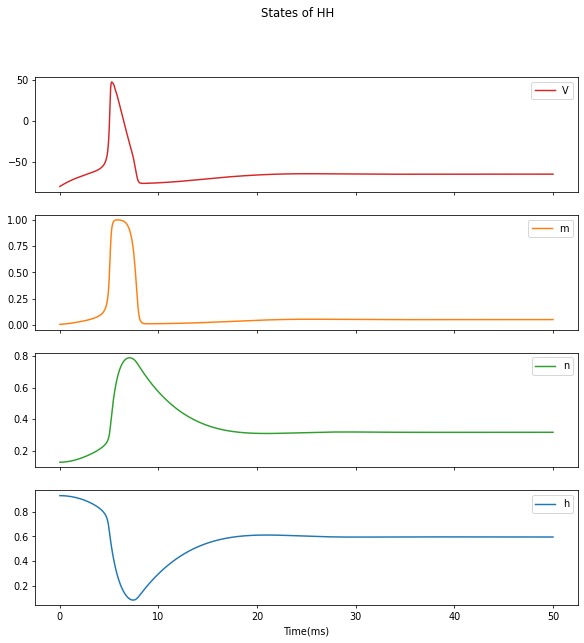

In [31]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex = True, figsize = (10,10), dpi=70)
fig.suptitle("States of HH")
t = np.linspace(0,50, 2001)
plt.xlabel("Time(ms)")

ax1.plot(t,datos[0], "tab:red")
ax1.legend("V")
ax2.plot(t,datos[1], "tab:orange")
ax2.legend("m")
ax3.plot(t,datos[2], "tab:green")
ax3.legend("n")
ax4.plot(t,datos[3], "tab:blue")
ax4.legend("h");

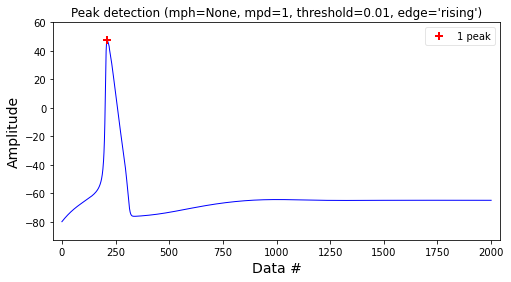

In [15]:
a = detect_peaks(datos[0],threshold = 0.01, show = True)

# Generación de datos con variación en parámetros

In [3]:
import funcion_var_params

In [20]:
v_ini = -70
physical_var = [100,500]
loc = 0.5
curr = [100,0.5,5]
tstop = 50
dt = 0.025

# el gl es glbar
#V_k
#e_k - > V_k
#variar solo gkbar, gnabar
#variar con valores de HH con la mitad y doble
var_mech = [49,0.5,260]
#[ 'gkbar', 'gl', 'gnabar']
datos = funcion_var_params.sim_HH_1_variar_params(v_ini, physical_var,loc, curr ,tstop,dt, var_mech)

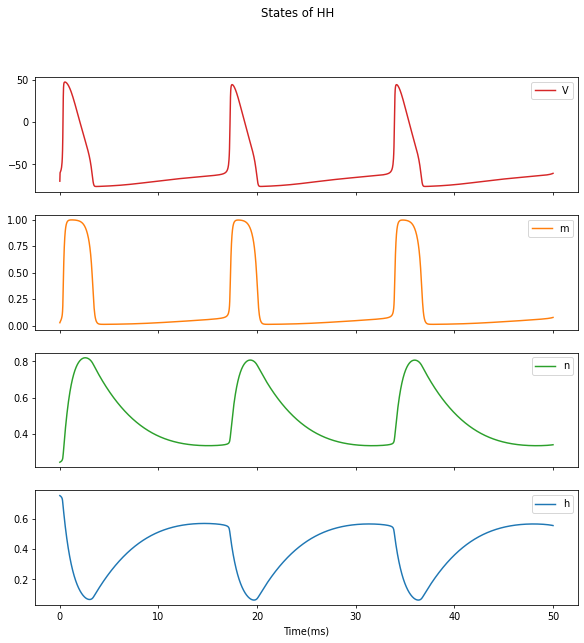

In [21]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex = True, figsize = (10,10), dpi=70)
fig.suptitle("States of HH")
t = np.linspace(0,50, 2001)
plt.xlabel("Time(ms)")

ax1.plot(t,datos[0], "tab:red")
ax1.legend("V")
ax2.plot(t,datos[1], "tab:orange")
ax2.legend("m")
ax3.plot(t,datos[2], "tab:green")
ax3.legend("n")
ax4.plot(t,datos[3], "tab:blue")
ax4.legend("h");

In [23]:
def generate_data_w_params(save_data, tstop, dt,largo_axon, diametro_axon, var_mech,volt_ini):
    """
    save_data: Boolean indicates if the data is going to be saved or not 
    tstop: Final time for the simulation
    dt: Time step
    largo_axon: Length of the axon
    diametro_axon: Diameter of the axon
    var_mech: Range for variables of the HH mechanism ['el', 'gk', 'gkbar', 'gl', 'gna', 'gnabar']
    volt_ini: Valores máximos y mínimos del voltaje
    """
    largo = int(1/dt)*tstop  #Largo de los datos
    
    #Rango de corriente: Amplitud, delay y duración
    #I_range = np.linspace(amp_min,amp_max, 3) 
    #I_delay = np.linspace(0,max_delay,3) 
    #I_dur = np.linspace(0, max_dur, 3)
    
    #Rango de variables del mecanismo
    gkbar = np.linspace(var_mech[0], var_mech[1], 10)
    gl = np.linspace(var_mech[2], var_mech[3], 10)
    gnabar = np.linspace(var_mech[4], var_mech[5], 10)
    #Valores del voltaje inicial
    volt = np.linspace(volt_ini[0],volt_ini[1],10) 
    
    nombres = [] #lista con nombres de los archivos
    #DataFrame vacio para guardar cada experimento
    data = pd.DataFrame(columns = ["V","m","n","h"],index=  np.linspace(0,tstop,largo+1))
    #Experimentos
    k=0
                        
    phys = [largo_axon,diametro_axon]
    loc = 0.5
    curr = [50,0.5,5] 

    for gk_bar in gkbar:
        for g_l in gl:
            for gna_bar in gnabar:
                for v in volt:
                    states = funcion_var_params.sim_HH_1_variar_params(v,phys,loc,curr,tstop,dt, [gk_bar, g_l, gna_bar])
                    data["V"]=[volt for volt in states[0]]
                    data["m"] = [round(m,3) for m in states[1]]
                    data["n"] = [round(n,3) for n in states[2]]
                    data["h"] = [round(h,3) for h in states[3]]


                    parametros = pd.DataFrame(columns = ['gkbar', 'gl', 'gnabar'],data = np.array([gk_bar, g_l, gna_bar]).reshape(1,3))
                    if save_data:
                        name = "dataHH_1box_exp"+ str(k)+".csv"
                        name_par = "paramsHH_1box_exp"+ str(k)+".csv"
                        nombres.append(name+"\n")
                        data.to_csv("C:/Users/DELL/Desktop/ACIP/Tutorial NEURON/Experimentos_HH/Datos/"+name)
                        parametros.to_csv("C:/Users/DELL/Desktop/ACIP/Tutorial NEURON/Experimentos_HH/Parametros/"+name_par)
                        k+=1
    return nombres

In [24]:
tstop = 50
dt = 0.025
#Giant squid config
largo_axon = 100
diametro_axon = 500
#['gkbar', 'gl', 'gnabar']
var_mech = [25,50,0.1,0.5,65,260]
volt_ini = [-80,0]
generate_data_w_params(True,tstop, dt,largo_axon, diametro_axon, var_mech, volt_ini)

['dataHH_1box_exp0.csv\n',
 'dataHH_1box_exp1.csv\n',
 'dataHH_1box_exp2.csv\n',
 'dataHH_1box_exp3.csv\n',
 'dataHH_1box_exp4.csv\n',
 'dataHH_1box_exp5.csv\n',
 'dataHH_1box_exp6.csv\n',
 'dataHH_1box_exp7.csv\n',
 'dataHH_1box_exp8.csv\n',
 'dataHH_1box_exp9.csv\n',
 'dataHH_1box_exp10.csv\n',
 'dataHH_1box_exp11.csv\n',
 'dataHH_1box_exp12.csv\n',
 'dataHH_1box_exp13.csv\n',
 'dataHH_1box_exp14.csv\n',
 'dataHH_1box_exp15.csv\n',
 'dataHH_1box_exp16.csv\n',
 'dataHH_1box_exp17.csv\n',
 'dataHH_1box_exp18.csv\n',
 'dataHH_1box_exp19.csv\n',
 'dataHH_1box_exp20.csv\n',
 'dataHH_1box_exp21.csv\n',
 'dataHH_1box_exp22.csv\n',
 'dataHH_1box_exp23.csv\n',
 'dataHH_1box_exp24.csv\n',
 'dataHH_1box_exp25.csv\n',
 'dataHH_1box_exp26.csv\n',
 'dataHH_1box_exp27.csv\n',
 'dataHH_1box_exp28.csv\n',
 'dataHH_1box_exp29.csv\n',
 'dataHH_1box_exp30.csv\n',
 'dataHH_1box_exp31.csv\n',
 'dataHH_1box_exp32.csv\n',
 'dataHH_1box_exp33.csv\n',
 'dataHH_1box_exp34.csv\n',
 'dataHH_1box_exp35.csv\n',
 '